<a href="https://colab.research.google.com/github/AyHaski/BigDataAnalyticsProject/blob/master/Kopie_von_Rapids_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

Sat Sep  5 11:53:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
1. removes incompatible files
1. Install RAPIDS libraries
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
1. If running v0.11 or higher, updates pyarrow library to 0.15.x.

In [1]:
# Install RAPIDS and Dask_ml
!pip install dask_ml
!pip install dask_cuda

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable


import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.15, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!  

# Data Imports and Load Data

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

_Note_: You must import nvstrings and nvcategory before cudf, else you'll get errors.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import nvstrings
import numpy as np
import cudf, cuml
import dask_cudf
import io, requests
import math
import gc
import cupy as cp

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

#Learning
from cuml.preprocessing.model_selection import train_test_split
from scipy.stats import uniform

# Linear Models
from cuml.linear_model import LinearRegression # Linear
from cuml.linear_model import LogisticRegression # Logisitc
from cuml.linear_model import ElasticNet # Elastic
from cuml.linear_model import Ridge # Ridge
from cuml.linear_model import Lasso # Lasso
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor # Mini Batch SGD Regressor

from cuml.solvers import SGD as cumlSGD # Stochastic Gradient Descent
from cuml.ensemble import RandomForestRegressor as cuRF # Random Forest
from cuml.neighbors import KNeighborsRegressor  # Nearest Neighbours
from cuml.svm import SVC # Support Vector Machines

from cuml import ForestInference
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from cuml.metrics.regression import r2_score
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.utils.fixes import loguniform

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: nvstrings will be removed in 0.15. Please use equivalent from libcudf
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
cudf.set_allocator("managed")
base_path='/content/drive/My Drive/bigData'

traintypes = {'fare_amount': 'float32',
              'pickup_datetime':'str',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'int8'}

cols = list(traintypes.keys())
usecols = cols

In [4]:
%%time
test_1 = cudf.read_csv(base_path +'/test.csv', usecols=cols, dtype=traintypes)
train_1 = cudf.read_csv(base_path +'/train.csv', usecols=cols, dtype=traintypes)

CPU times: user 4.64 s, sys: 4.03 s, total: 8.67 s
Wall time: 1min 58s


In [5]:
train_1.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844307,40.721321,-73.841614,40.712273,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982742,40.761269,-73.991234,40.750565,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987137,40.733139,-73.991570,40.758095,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968102,40.768009,-73.956665,40.783768,1


In [6]:
train_1['pickup_datetime'] = train_1['pickup_datetime'].astype('datetime64[ns]')
test_1['pickup_datetime'] = test_1['pickup_datetime'].astype('datetime64[ns]')

In [7]:
#Getting integer numbers from the pickup_datetime
train_1["hour"] = train_1.pickup_datetime.dt.hour
train_1["weekday"] = train_1.pickup_datetime.dt.weekday
train_1["month"] = train_1.pickup_datetime.dt.month
train_1["year"] = train_1.pickup_datetime.dt.year

test_1["hour"] = test_1.pickup_datetime.dt.hour
test_1["weekday"] = test_1.pickup_datetime.dt.weekday
test_1["month"] = test_1.pickup_datetime.dt.month
test_1["year"] = test_1.pickup_datetime.dt.year

In [8]:
train_1.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
0,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010
2,5.7,2011-08-18 00:35:00,-73.982742,40.761269,-73.991234,40.750565,2,0,3,8,2011
3,7.7,2012-04-21 04:30:42,-73.987137,40.733139,-73.991570,40.758095,1,4,5,4,2012
4,5.3,2010-03-09 07:51:00,-73.968102,40.768009,-73.956665,40.783768,1,7,1,3,2010


# Data Cleaning and Analysis


Bevor mit den Daten gearbeitet werden kann sollten diese betrachtet um mögliche Null Werte und Outliers zu finden und zu entfernen. So können auch schon mögliche Abhängigkeiten zwischen den Datenspalten erkannt werden.


## Null Data

In [9]:
print("Shape of Training Data after dropping columns",train_1.shape)
print("Shape of Testing Data after dropping columns",test_1.shape)

Shape of Training Data after dropping columns (55423856, 11)
Shape of Testing Data after dropping columns (9914, 10)


In [10]:
train_1.nans_to_nulls()
train_1 = train_1.dropna()
print("Shape of Training Data after dropping columns",train_1.shape)
print("Shape of Testing Data after dropping columns",test_1.shape)

Shape of Training Data after dropping columns (55423480, 11)
Shape of Testing Data after dropping columns (9914, 10)


In [11]:
train_1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
count,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07,5.542348e+07
mean,1.134501e+01,-7.250973e+01,3.991982e+01,-7.251121e+01,3.992068e+01,1.685087e+00,1.350978e+01,3.041161e+00,6.266239e+00,2.011739e+03
std,2.071087e+01,1.284877e+01,9.642324e+00,1.278220e+01,9.633346e+00,1.310113e+00,6.517377e+00,1.948911e+00,3.435531e+00,1.860079e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442024e+03,-3.547886e+03,-1.270000e+02,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03
25%,6.000000e+00,-7.399206e+01,4.073493e+01,-7.399139e+01,4.073403e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398016e+01,4.075315e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03
max,9.396336e+04,3.457625e+03,3.408790e+03,3.457622e+03,3.537133e+03,5.100000e+01,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03


## Fare amount and Passenger Count

In [12]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()

Text(0.5, 1.0, 'Verteilung der Gäste')

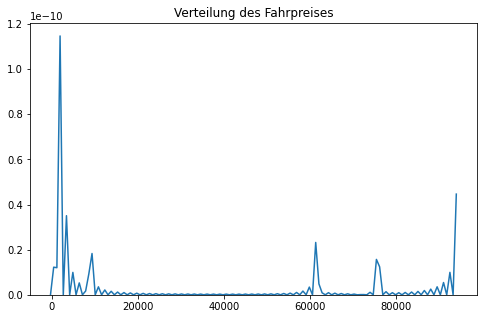

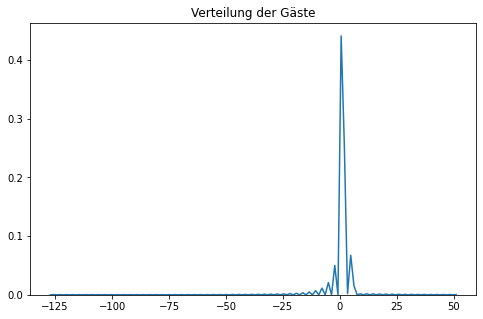

In [13]:
plt.figure(figsize=(8,5))
sns.kdeplot(fare_amount).set_title("Verteilung des Fahrpreises")

plt.figure(figsize=(8,5))
sns.kdeplot(passenger_count).set_title("Verteilung der Gäste")

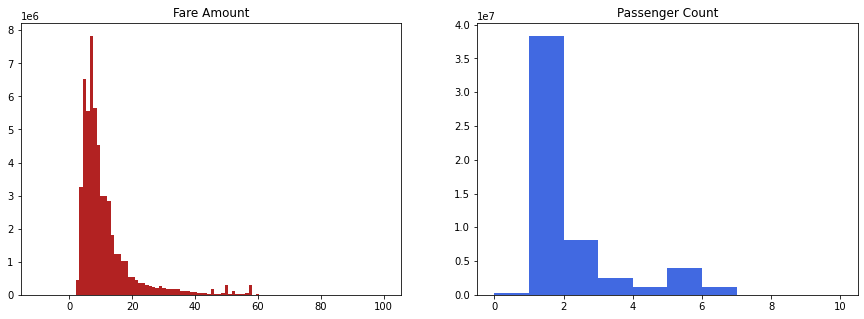

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.hist(fare_amount, bins=100, range=(-10,100), color='firebrick')
ax1.set_title('Fare Amount')

ax2.hist(passenger_count,bins=10, range=(0,10), color='royalblue')
ax2.set_title('Passenger Count')
plt.show()

Insgesamt sieht man durch diese Graphen das meistens 1 bis 2 Passagiere ein Taxi verwenden und das meistens die Gebühren zwischen 2 und 15 Dollar liegen. 

Von der Graphen und der Informationen kann geshen werden, das es Einträge gibt die unter 0 sind für die Fare_mount und Passenger_count. Diese Einträge könnten Fehler sein und werden entfernt, da sie das Ergebnis ins negative beeinflüssen können. Für die Passenger_Count gibt es zudem Einträge, welche über 8 Passagiere angibt, was Logistisch nicht möglich ist, so werden diese Einträge auch entfernt.

In [41]:
train_1 = train_1[(train_1['fare_amount'] > 0) & (train_1['fare_amount'] < 20000)]
train_1 = train_1[(train_1['passenger_count'] > 0) & (train_1['passenger_count'] < 6)]

## Longitude and Latitude

Als nächstes werden die Pickup und Dropoff Punkte betrachtet. Wir durch die Informationen, welche durch das .describe erhalten haben zu sehen ist, gibt es einige sehr entfernte Werte. Der Mittelpunkt von Newyork liegt bei einer Latitude 40 und Longitude -74.

Die Minimalen und Maximalen Werte wurden nochmal in einer kleinen Tabelle zusammengefasst.


|          | Dropoff   | Pickup    |
| -------- |:---------:| ---------:|
| Max Long | 3408.790  | 3457.625  |
| Max Lat  | 3537.133  | 3408.790  |
| Min Long | -3442.024 | -3442.060 |
| Max Long | -3547.886 | -3492.264 |

Betrachtet man eine Heatmap der Punkte wird deutlich das es viele Punkte gibt die außerhalb von New York liegen. Daher sollten die Daten in eine Art Bounding Box eingegrenzt werden, womit das Ergebnis der Vorhersage genauer werden sollte.






In [16]:
dropoff_long = train_1['dropoff_longitude'].to_array()
dropoff_lat = train_1['dropoff_latitude'].to_array()
pickup_long = train_1['pickup_longitude'].to_array()
pickup_lat = train_1['pickup_latitude'].to_array()

In [17]:
city_long_border = (-72, -76)
city_lat_border = (38, 42)

city_long_border_zoomed = (-73.0, -75.5)
city_lat_border_zoomed = (39.5, 41.5)

(-72.0, -76.0)

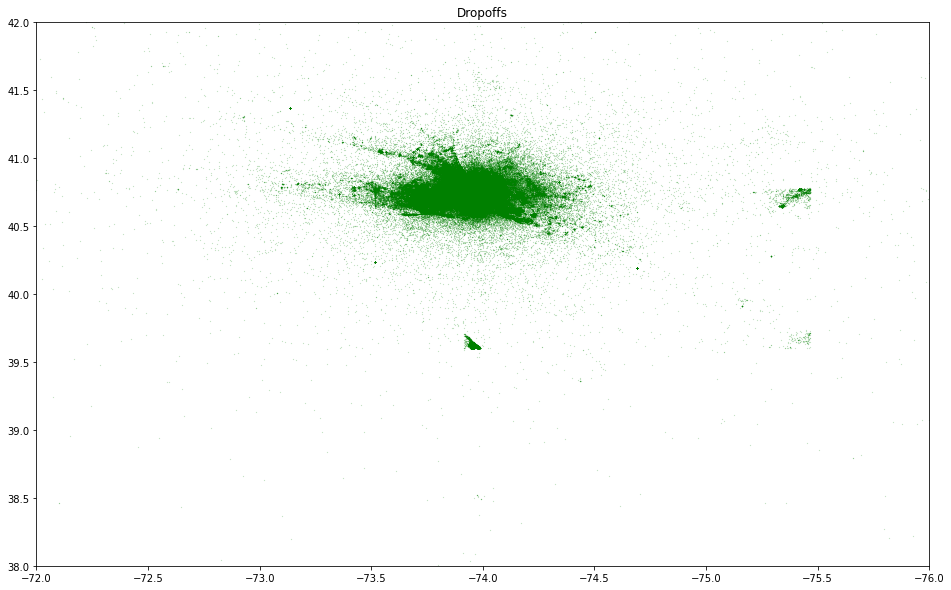

In [18]:
plt.figure(figsize=(16,10))
plt.scatter(dropoff_long, dropoff_lat,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-73.0, -75.5)

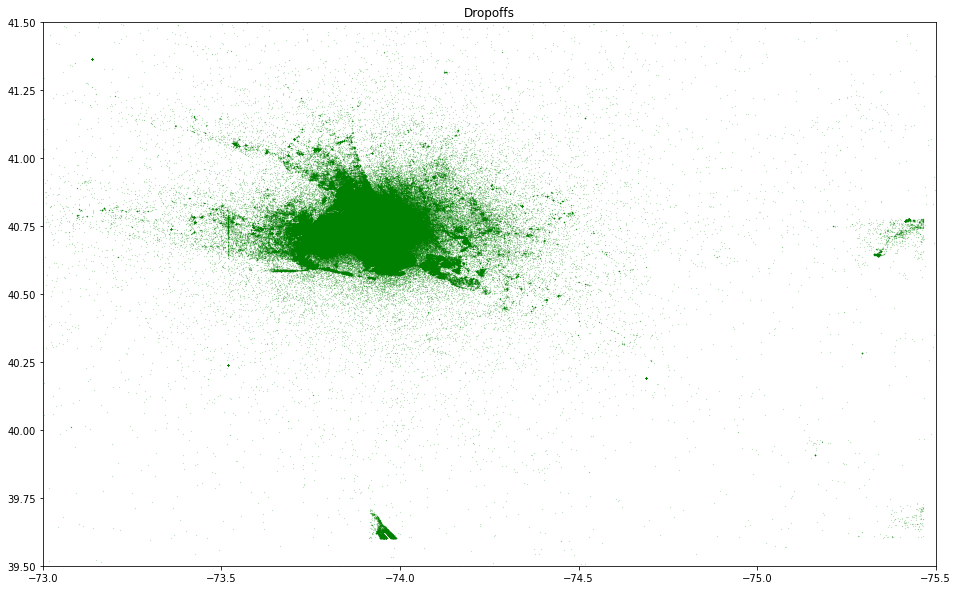

In [19]:
plt.figure(figsize=(16,10))
plt.scatter(dropoff_long, dropoff_lat,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border_zoomed)
plt.xlim(city_long_border_zoomed)

(-72.0, -76.0)

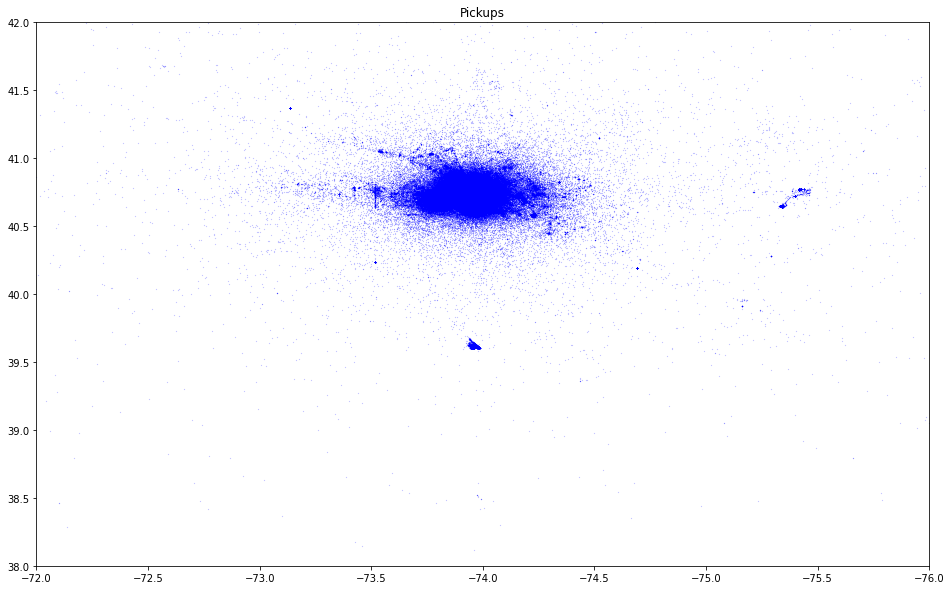

In [20]:
plt.figure(figsize=(16,10))
plt.scatter(pickup_long, pickup_lat,
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-73.0, -75.5)

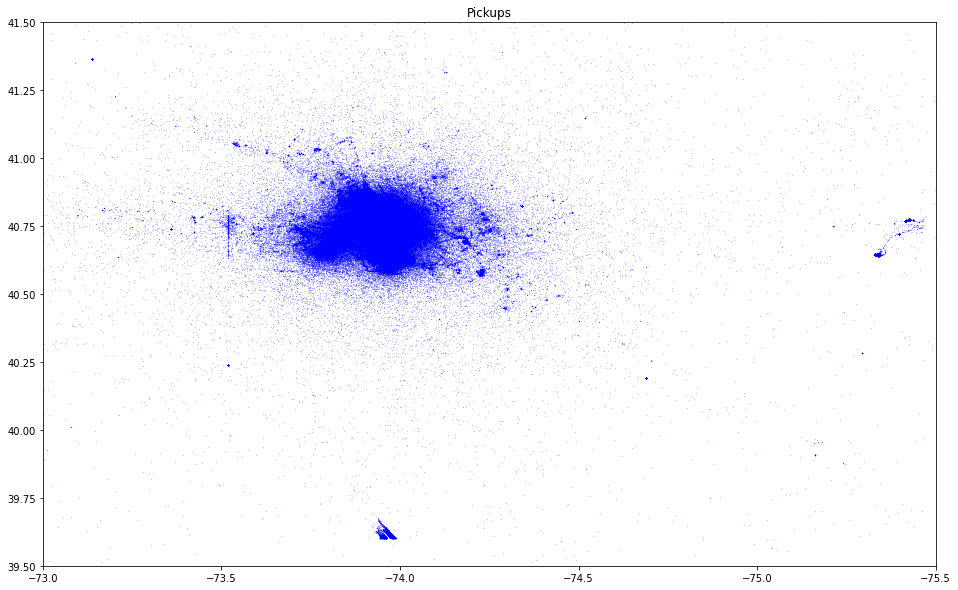

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(pickup_long, pickup_lat,
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border_zoomed)
plt.xlim(city_long_border_zoomed)

Da es zwei Anhäufungen außerhalb von New York gibt wurde diese bei der Eingrenzung berücksichtig, da es anscheinend bekanntere Orte sind. Die Daten werden au einer Longtitude von (-73.0, -75.5) und Latitude von (39.5, 41.5) eingegrenzt

In [22]:
#Manche Koordinaten sind supper weit weg werden entfernt
train_1 = train_1[(train_1['pickup_longitude'] < -73) & (train_1['pickup_longitude'] > -75.5)]
train_1 = train_1[(train_1['pickup_latitude'] > 39.5) & (train_1['pickup_latitude'] < 41.5)]
train_1 = train_1[(train_1['dropoff_longitude'] < -73) & (train_1['dropoff_longitude'] > -75.5)]
train_1 = train_1[(train_1['dropoff_latitude'] > 39.5) & (train_1['dropoff_latitude'] < 41.5)]
train_1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
count,5.292485e+07,5.292485e+07,5.292485e+07,5.292485e+07,5.292485e+07,5.292485e+07,5.292485e+07,5.292485e+07,5.292485e+07,5.292485e+07
mean,1.131899e+01,-7.397526e+01,4.075093e+01,-7.397438e+01,4.075127e+01,1.597405e+00,1.351229e+01,3.040898e+00,6.268182e+00,2.011711e+03
std,2.103654e+01,4.062600e-02,3.194300e-02,3.935100e-02,3.523100e-02,1.154426e+00,6.518841e+00,1.949069e+00,3.435888e+00,1.865480e+00
min,1.000000e-02,-7.549814e+01,3.951453e+01,-7.549931e+01,3.950031e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03
25%,6.000000e+00,-7.399228e+01,4.073655e+01,-7.399159e+01,4.073556e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03
50%,8.500000e+00,-7.398210e+01,4.075337e+01,-7.398061e+01,4.075385e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03
75%,1.250000e+01,-7.396831e+01,4.076754e+01,-7.396535e+01,4.076840e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03
max,9.396336e+04,-7.300002e+01,4.149911e+01,-7.300057e+01,4.149802e+01,5.000000e+00,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03


## Abhängigkeiten

Am Ende sollten die Daten noch auf verschiedene Abhängigkeiten gecheckt werden. Also wird überprüft ob die Fare_amount etwas mit der Datetime, den Passagieren und die Distanz zu tun hat.
Für das sollte muss zuerst noch die Distanz berechnet werden. Zwei verschiedene Berechnung wurden auspobiert während dem Anfang des Projekts. Einmal die absolute Distanz und einmal die Distanz mit der Haversine Formel. Bei den Anfangsversuchen mit simplere Modelle erschließte sich ein Score-Unterschied von 1-2 Punkten. Somit wurde sich letztendlich für die Harvesine Formel entschieden.  

### Distance in miles

In [23]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [24]:
train_1['distance_miles'] = distance(train_1['pickup_latitude'], train_1['pickup_longitude'], \
                                      train_1['dropoff_latitude'], train_1['dropoff_longitude'] )
test_1['distance_miles'] = distance(test_1['pickup_latitude'], test_1['pickup_longitude'], \
                                      test_1['dropoff_latitude'], test_1['dropoff_longitude'] )
train_1['distance_miles'].describe()

count    5.292485e+07
mean     1.874523e+00
std      2.692713e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.366828e+00
75%      2.424855e+00
max      1.136033e+02
Name: distance_miles, dtype: float64

In [61]:
fare_amount = train_1[train_1['fare_amount']<1000]['fare_amount'].to_array()
passenger_count = train_1[train_1['fare_amount']<1000]['passenger_count'].to_array()
hour = train_1[train_1['fare_amount']<1000]["hour"].to_array()
weekday = train_1[train_1['fare_amount']<1000]["weekday"].to_array()
month =train_1[train_1['fare_amount']<1000]["month"].to_array()
year = train_1[train_1['fare_amount']<1000]["year"].to_array()

Text(0, 0.5, 'Fare')

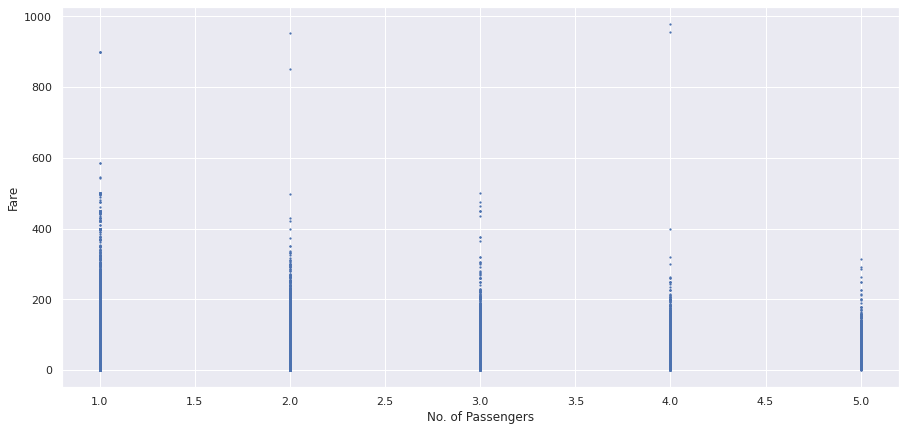

In [62]:
plt.figure(figsize=(15,7))
plt.scatter(x=passenger_count, y=fare_amount, s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

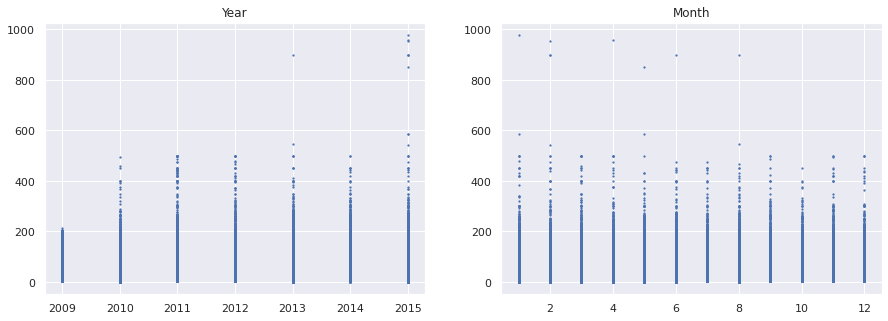

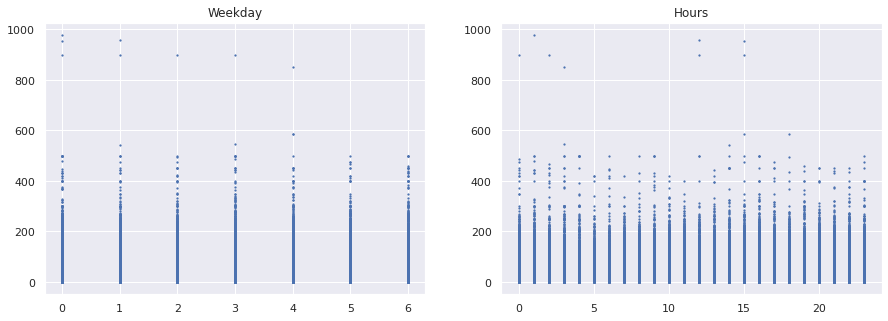

In [63]:
fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(x=year, y=fare_amount, s=1.5)
ax1.set_title('Year')

ax2.scatter(x=month, y=fare_amount, s=1.5)
ax2.set_title('Month')
plt.ylim=(0,1000)
plt.show()

fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(x=weekday, y=fare_amount, s=1.5)
ax1.set_title('Weekday')

ax2.scatter(x=hour, y=fare_amount, s=1.5)
ax2.set_title('Hours')
plt.show()

# Dropping Columns not needed anymore


In [ ]:
drop_columns = ['pickup_datetime','dropoff_latitude','pickup_latitude','dropoff_longitude','pickup_longitude']
train_1=train_1.drop(drop_columns,axis=1)
test_1=test_1.drop(drop_columns,axis=1)

In [ ]:
train_1.head()

,fare_amount,passenger_count,hour,weekday,month,year,distance_miles
0,4.5,1,17,0,6,2009,0.000000
1,16.9,1,16,1,1,2010,5.244397
2,5.7,2,0,3,8,2011,0.000000
3,7.7,1,4,5,4,2012,1.932986
4,5.3,1,7,1,3,2010,1.366828


In [ ]:
test_1.head()

,passenger_count,hour,weekday,month,year,distance_miles
0,1,13,1,1,2015,1.366828
1,1,13,1,1,2015,1.366828
2,1,11,5,10,2011,0.000000
3,1,21,5,12,2012,1.366828
4,1,21,5,12,2012,3.226874


# Linear Regression

In [ ]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  42337728
Number of records in validation data  10584432
(42337728, 6)
(10584432, 6)
(42337728,)
(10584432,)


In [ ]:
lm = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "eig")
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse = r2_score(y_pred, y_test)
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  0.2914084792137146


In [ ]:
y_pred=lm.predict(test_1)
y_pred

0        9.783966
1        9.783966
2        5.478973
3        9.694916
4       14.977570
          ...    
9909    10.014099
9910    12.425690
9911    39.885895
9912    20.667664
9913     5.894531
Length: 9914, dtype: float32

In [ ]:
gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.783966
1,2015-01-27 13:08:24.0000003,9.783966
2,2011-10-08 11:53:44.0000002,5.478973
3,2012-12-01 21:12:12.0000002,9.694916
4,2012-12-01 21:12:12.0000003,14.977570


In [ ]:
gdf_submission.to_csv(base_path + '/logRegRapidSubmissionMilesDistance3.csv',index=False)

# Ridge Regression


In [ ]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  42337728
Number of records in validation data  10584432
(42337728, 6)
(10584432, 6)
(42337728,)
(10584432,)


In [ ]:
alpha = np.array([1e-5])  # 1.0
solver = 'eig' # svd cd eig

ridge_params = {
    'alpha': 1e-5,
    'solver': 'eig'
}

ridge = Ridge(**ridge_params)
result_ridge = ridge.fit(X_train,y_train)

y_pred=result_ridge.predict(X_test)
ridge_rmse = r2_score(y_pred, y_test)
print("RMSE for Ridge_rmse Regression is ", ridge_rmse)

RMSE for Ridge_rmse Regression is  0.30239927768707275


In [ ]:
from sklearn.utils.fixes import loguniform

params_rf = {
    "alpha": loguniform(1e-4, 1e0), # Default = 6
    "solver": ['eig', 'cd'], #default = 0.3
}
ridge = Ridge()

clf = RandomizedSearchCV(ridge, params_rf, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train)

In [ ]:
 best_model.best_estimator_.get_params()

{'alpha': 0.004656804637919565,
 'fit_intercept': True,
 'normalize': False,
 'solver': 'eig'}

In [ ]:
y_pred=result_ridge.predict(test_1)
y_pred

0        9.816284
1        9.816284
2        5.573151
3        9.722198
4       14.917328
          ...    
9909     9.971344
9910    12.322968
9911    39.341492
9912    20.449219
9913     5.913696
Length: 9914, dtype: float32

In [ ]:
gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.to_csv(base_path + '/ridgeRegSubmission.csv',index=False)
gdf_submission.head()

# Lasso Regression


In [ ]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  42337728
Number of records in validation data  10584432
(42337728, 6)
(10584432, 6)
(42337728,)
(10584432,)


In [ ]:
alpha = np.array([1e-5])
max_iter = 100
tol = 1e-3
selection = 'cyclic' # cyclic random

lasso_params = {
    'alpha': 1e-5,
    'max_iter': 100,
    'tol': 1e-3,
    'selection': 'cyclic'
}

lasso = Lasso(**lasso_params)
result_lasso = lasso.fit(X_train,y_train)
y_pred=result_lasso.predict(X_test)
lasso_rmse = r2_score(y_pred, y_test)
print("RMSE for lasso Regression is ", lasso_rmse)

RMSE for lasso Regression is  0.2825837731361389


In [ ]:
params_lasso = {
    "alpha": loguniform(1e-4, 1e0), # Default = 6
    "max_iter": np.arange(start=500, stop = 3000, step = 500), # Default = 6
    "tol": loguniform(1e-4, 1e0), # Default = 6
    "selection": ['cyclic', 'random'], #default = 0.3
}
lasso = Lasso()

clf = RandomizedSearchCV(lasso, params_lasso, random_state=1, n_iter=1000, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train)

In [ ]:
 best_model.best_estimator_.get_params()

{'alpha': 0.004656804637919565,
 'fit_intercept': True,
 'max_iter': 2500,
 'normalize': False,
 'selection': 'cyclic',
 'tol': 0.00010010539860510489}

In [ ]:
y_pred=result_ridge.predict(test_1)
y_pred

0        9.816284
1        9.816284
2        5.573151
3        9.722198
4       14.917328
          ...    
9909     9.971344
9910    12.322968
9911    39.341492
9912    20.449219
9913     5.913696
Length: 9914, dtype: float32

In [ ]:
gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.to_csv(base_path + '/ridgeRegSubmission.csv',index=False)
gdf_submission.head()

# Random Forest Regression Model

In [ ]:
cu_rf_params = {
    'n_estimators': 100,
    'max_features': 'auto', #default = 0.3
    'max_depth': 16,
    'n_bins': 8
}

In [ ]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)


In [ ]:
params_cu_rf = {
   # "max_depth": np.arange(start=3, stop = 17, step = 2), # Default = 6
  #  'n_bins':  np.arange(start=4, stop = 12, step = 2),
    #"max_features": [0.1, 0.50, 0.75, 'auto'], #default = 0.3
    "n_estimators": [100, 200, 300, 400, 500]
}

cu_rf = cuRF()

clf = RandomizedSearchCV(cu_rf, params_cu_rf, random_state=1, n_iter=1000, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 5 is smaller than n_iter=1000. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [ ]:
best_model.best_estimator_.get_params()

In [ ]:
cu_rf = cuRF(**cu_rf_params)
cu_rf.fit(X_train, y_train)
y_pred=cu_rf.predict(X_test)

In [ ]:
rf_rmse = r2_score(y_pred, y_test)
print("RMSE for RF Regression is ",rf_rmse)

RMSE for RF Regression is  0.265926718711853


In [ ]:
y_pred=cu_rf.predict(test_1)
y_pred

0        9.787024
1        9.787024
2        5.867246
3        8.939384
4       15.635692
          ...    
9909     8.973536
9910    11.656147
9911    34.585255
9912    27.609804
9913     6.255931
Length: 9914, dtype: float32

In [ ]:
gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.787024
1,2015-01-27 13:08:24.0000003,9.787024
2,2011-10-08 11:53:44.0000002,5.867246
3,2012-12-01 21:12:12.0000002,8.939384
4,2012-12-01 21:12:12.0000003,15.635692


In [ ]:
gdf_submission.to_csv(base_path + '/randomForestSubmissionDefaultParams1000est.csv',index=False)

# XGB without HPO

In [ ]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# instantiate params
params = {}

# booster params
booster_params = {}

booster_params['tree_method'] = 'gpu_hist'
params.update(booster_params)

# learning task params
learning_task_params = {}
learning_task_params['eval_metric'] = 'rmse'
learning_task_params['objective'] = 'reg:squarederror'
params.update(learning_task_params)

params_xgb = {
    "max_depth": 12, # Default = 6
    "alpha" : 0.001, # default = 0
    "learning_rate": 0.1, #default = 0.3
    "min_child_weight" : 2, # default = 1
    "n_estimators": 1000
}
params.update(params_xgb)

print(params)

{'tree_method': 'gpu_hist', 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'max_depth': 12, 'alpha': 0.001, 'learning_rate': 0.1, 'min_child_weight': 2, 'n_estimators': 1000}


In [ ]:
# model training settings
evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
num_round = 100

In [ ]:
bst = xgb.train(params, dtrain, num_round, evallist)

In [ ]:
dtest = xgb.DMatrix(test_1)
y_pred_xgb = bst.predict(dtest)
print(y_pred_xgb)

[ 9.425025   9.425025   5.595852  ... 56.41775   23.252817   6.1432843]


In [ ]:
gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
gdf_submission['fare_amount']= y_pred_xgb

gdf_submission.to_csv(base_path + '/XGBBoostSubmissionW1000Rounds.csv',index=False)
gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.425025
1,2015-01-27 13:08:24.0000003,9.425025
2,2011-10-08 11:53:44.0000002,5.595852
3,2012-12-01 21:12:12.0000002,9.125943
4,2012-12-01 21:12:12.0000003,16.820873


 # SVM Regression Model (SVC)

# HPO Tests


# HPO Functions


In [ ]:
N_FOLDS = 3
N_ITER = 25

def do_HPO(model, gridsearch_params, scorer, X, y, mode='gpu-Grid', n_iter=10):
    """
        Perform HPO based on the mode specified
        
        mode: default gpu-Grid. The possible options are:
        1. gpu-grid: Perform GPU based GridSearchCV
        2. gpu-random: Perform GPU based RandomizedSearchCV
        
        n_iter: specified with Random option for number of parameter settings sampled
        
        Returns the best estimator and the results of the search
    """
    if mode == 'gpu-grid':
        print("gpu-grid selected")
        clf = dcv.GridSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer)
    elif mode == 'gpu-random':
        print("gpu-random selected")
        clf = dcv.RandomizedSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer,
                               n_iter=n_iter)

    else:
        print("Unknown Option, please choose one of [gpu-grid, gpu-random]")
        return None, None
    res = clf.fit(X, y)
    print("Best clf and score {} {}\n---\n".format(res.best_estimator_, res.best_score_))
    return res.best_estimator_, res

In [ ]:
def accuracy_score_wrapper(y, y_hat): 
    """
        A wrapper function to convert labels to float32, 
        and pass it to accuracy_score.
        
        Params:
        - y: The y labels that need to be converted
        - y_hat: The predictions made by the model
    """
    y = y.astype("float32") # cuML RandomForest needs the y labels to be float32
    return accuracy_score(y, y_hat, convert_dtype=True)

accuracy_wrapper_scorer = make_scorer(accuracy_score_wrapper)
cuml_accuracy_scorer = make_scorer(accuracy_score, convert_dtype=True)

# Random Forest HPO


In [ ]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
cluster = LocalCUDACluster(dashboard_address="127.0.0.1:8005")
client = Client(cluster)

client

/usr/local/lib/python3.6/site-packages/distributed/client.py:1137: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.18.5 | 1.18.5    | 1.19.1  |
| tornado | 5.1.1  | 5.1.1     | 6.0.4   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:40867 Dashboard: http://127.0.0.1:8005/status,Cluster Workers: 1 Cores: 1 Memory: 27.39 GB


In [ ]:
params_rf = {
    "max_depth": np.arange(start=3, stop = 15, step = 2), # Default = 6
    "max_features": [0.1, 0.50, 0.75, 'auto'], #default = 0.3
    "n_estimators": [100, 200, 500, 1000]
 }

mode = "gpu-random"
model_rf = cuRF()

X_cpu = X_train.to_pandas()
y_cpu = y_train.to_array()

X_test_cpu = X_test.to_pandas()
y_test_cpu = y_test.to_array()

res, results = do_HPO(model_rf,
                          params_rf,
                          cuml_accuracy_scorer,
                          X_train,
                          y_cpu,
                          mode=mode)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

gpu-random selected


# XGBoost with HPO


Für die Hyperparameter Optimierung wurde dass Notebook als Vorlage genommen https://github.com/rapidsai/cloud-ml-examples/blob/main/dask/notebooks/HPO_demo.ipynb

Ohne die Verwendung eines Clusters war es sonst nicht möglich eine HPO durchzuführen, da es immer wieder zu OutOfMemory Exceptions kam.

In [ ]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
cluster = LocalCUDACluster(dashboard_address="127.0.0.1:8005")
client = Client(cluster)

client

/usr/local/lib/python3.6/site-packages/distributed/client.py:1137: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.18.5 | 1.18.5    | 1.19.1  |
| tornado | 5.1.1  | 5.1.1     | 6.0.4   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:33437 Dashboard: http://127.0.0.1:8005/status,Cluster Workers: 1 Cores: 1 Memory: 27.39 GB


In [ ]:
# For xgb_model
model_gpu_xgb = xgb.XGBRegressor(tree_method='gpu_hist')

# More range 
params_xgb = {
    "max_depth": np.arange(start=3, stop = 15, step = 3), # Default = 6
    "alpha" : np.logspace(-3, -1, 5), # default = 0
    "learning_rate": [0.05, 0.1, 0.15], #default = 0.3
    "min_child_weight" : np.arange(start=2, stop=10, step=3), # default = 1
    "n_estimators": [100, 200, 1000]
}

In [ ]:
X_cpu = X_train.to_pandas()
y_cpu = y_train.to_array()

X_test_cpu = X_test.to_pandas()
y_test_cpu = y_test.to_array()

In [ ]:
mode = "gpu-random"

res, results = do_HPO(model_gpu_xgb,
                                   params_xgb,
                                   cuml_accuracy_scorer,
                                   X_train,
                                   y_cpu,
                                   mode=mode,
                                   n_iter=2)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

/usr/local/lib/python3.6/site-packages/distributed/client.py:1137: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.18.5 | 1.18.5    | 1.19.1  |
| tornado | 5.1.1  | 5.1.1     | 6.0.4   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


gpu-random selected


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [ ]:
y_pred = res.fit(X_train, y_cpu).predict(X_test)
score = accuracy_score(y_pred, y_test_cpu.astype('float32'), convert_dtype=True)
print("{} model accuracy: {}".format(mode, score))

gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.to_csv(base_path + '/xgbBoostWithRandomSearchCVSubmission.csv',index=False)
gdf_submission.head()

# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib